Data manipulations
---------------------------------------

A matrix transformation is a matrix multiplication between a transformation matrix M and a data matrix D that gives you a manipulated data matrix D' as output.

We can use matrix multiplications to transform our data (our data points, represented as feature vectors).

Let's load and plot the data.
This data comes from https://www.kaggle.com/tolgahancepel/toyota-corolla.

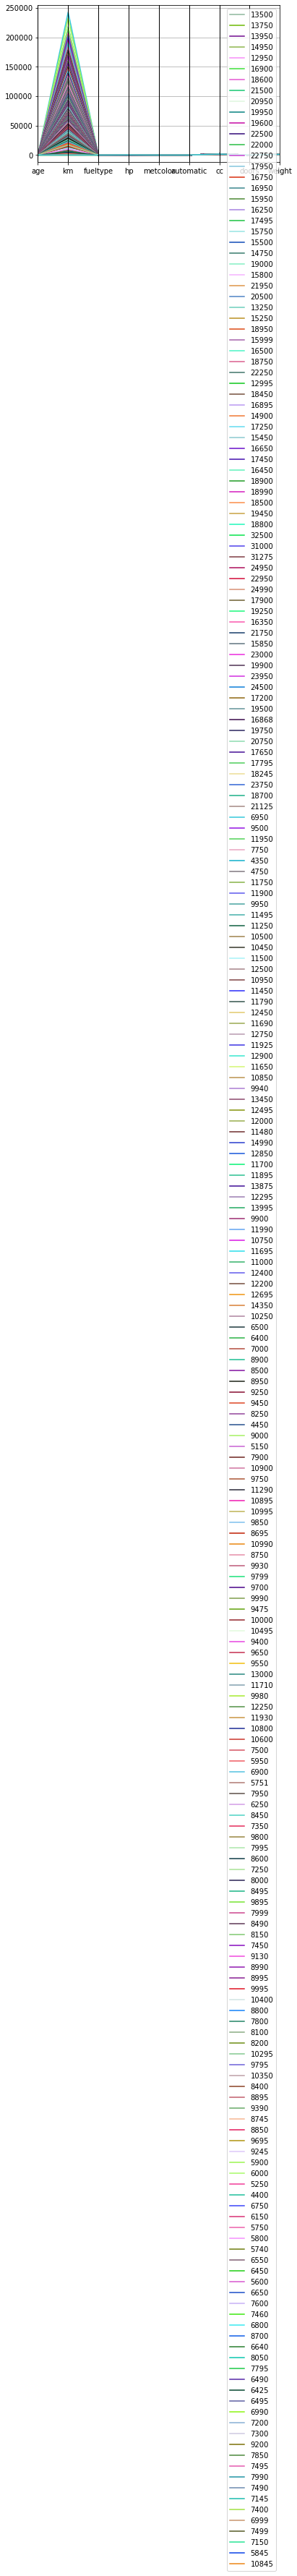

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import pandas as pd
import seaborn as sns

data = np.array(np.genfromtxt('CS252S22/data/ToyotaCorolla.csv', delimiter=',', converters={3: lambda x: 1 if x == 'Diesel' else 0}, skip_header=1, dtype=int, encoding=None))  

# getting a pandas dataframe so I can visualize the data
df = pd.DataFrame(data, columns=["price", "age", "km", "fueltype", "hp", "metcolor", "automatic", "cc", "doors", "weight"])

# a parallel coordinates plot is useful for figuring out if any variables are more predictive of the dependent variable (price) than any others
pd.plotting.parallel_coordinates(df, "price")
plt.show()

I can't see my data!!

<AxesSubplot:xlabel='km', ylabel='price'>

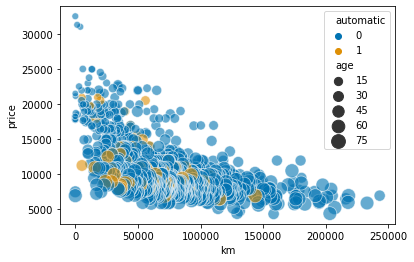

In [15]:
# I can't decide if doors or automatic are more important; how might I decide?
sns.scatterplot(x="km", y="price", size="age", hue ="automatic", palette="colorblind", sizes=(40, 200) , alpha=.6, data=df)

I still can't see my data!

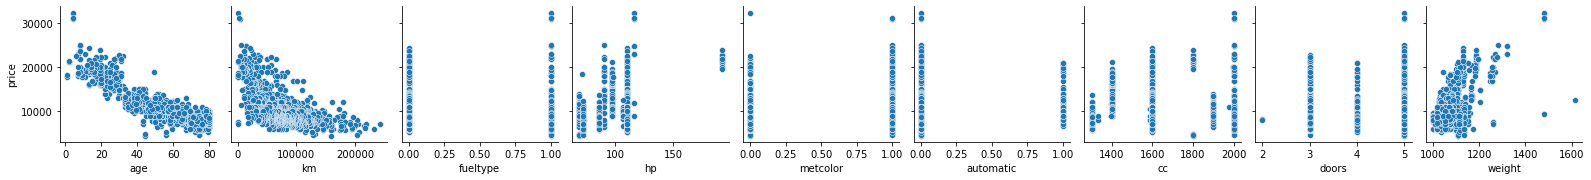

In [16]:
sns.pairplot(df, y_vars = ["price"], x_vars = ["age", "km", "fueltype", "hp", "metcolor", "automatic", "cc", "doors", "weight"], kind = "scatter")

Let's get some **summary statistics**.

In [17]:
def getSummaryStatistics(data):
    return np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0, dtype=int)])

def getShapeType(data):
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

[[ 32500     80 243000      1    192      1      1   2000      5   1615]
 [  4350      1      1      0     69      0      0   1300      2   1000]
 [ 10730     55  68533      0    101      0      0   1566      4   1072]]
((1436, 10), dtype('int32'))


Let's **reduce the data** to two dimensions, just price and age, since age looks like the one with the clearest correlation with price.

In [18]:
# How are we going to get just those two columns?
reducedData = data[:, 0:2]

# What if we just wanted price and km?
# reducedData = data[np.ix_(np.arange(data.shape[0]), [0, 2])]

print(getSummaryStatistics(reducedData))
print(getShapeType(reducedData))

[[32500    80]
 [ 4350     1]
 [10730    55]]
((1436, 2), dtype('int32'))


We need to add a dummy column of ones so we can do the matrix multiplications for these transformations. Why? See https://www.sciencedirect.com/topics/mathematics/homogeneous-coordinate.

homogenized data
[[32500    80     1]
 [ 4350     1     1]
 [10730    55     1]]
((1436, 3), dtype('int32'))


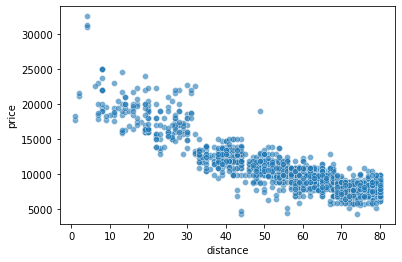

In [19]:
# How do we append a whole column?
homogenizedData = np.append(reducedData, np.array([np.ones(reducedData.shape[0], dtype=int)]).T, axis=1)
# alternatively, try np.column_stack:
# homogenizedData = np.column_stack([reducedData, np.array(np.ones(reducedData.shape[0]), dtype=int)])
print("homogenized data")
print(getSummaryStatistics(homogenizedData))
print(getShapeType(homogenizedData))

def plot2d(data):
    sns.scatterplot(x="distance", y="price", palette="colorblind", sizes=(40, 200) , alpha=.6, data=pd.DataFrame(data, columns=["price", "distance", ""]))
    
plot2d(homogenizedData)

Let's **translate** that price column so that it too starts at 0.

transformMatrix
((3, 3), dtype('int32'))
[[    1     0 -4350]
 [    0     1     0]
 [    0     0     0]]
after translation, translatePriceData
[[28150    80     0]
 [    0     1     0]
 [ 6380    55     0]]
((1436, 3), dtype('int32'))


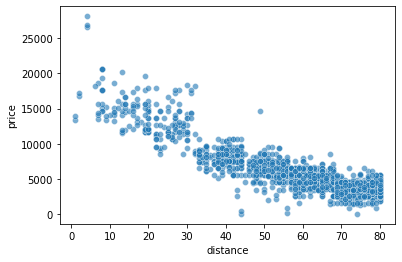

In [20]:
# we need to define a transformation matrix that will allow us to shift the price variable; this one will be the identity matrix with the translation specified in an extra last column
translateTransform = np.eye(homogenizedData.shape[1], dtype=int)
translateTransform[:, 2] = np.array([-homogenizedData[:, 0].min(), 0, 0], dtype=int)
print("transformMatrix")
print(getShapeType(translateTransform))
print(translateTransform)

# now we need to do the translation
translatePriceData = (translateTransform@homogenizedData.T).T
print("after translation, translatePriceData")
print(getSummaryStatistics(translatePriceData))
print(getShapeType(translatePriceData))
plot2d(translatePriceData)

Let's **scale** that age column so it's months instead of years

transformMatrix
((3, 3), dtype('int32'))
[[ 1  0  0]
 [ 0 12  0]
 [ 0  0  1]]
after scaling, scaleAgeData
[[32500   960     1]
 [ 4350    12     1]
 [10730   671     1]]
((1436, 3), dtype('int32'))


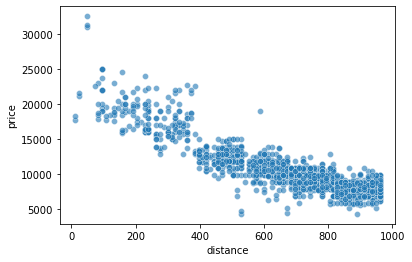

In [21]:
scaleTransform = np.eye(homogenizedData.shape[1], dtype=int) * [1, 12, 1]
print("transformMatrix")
print(getShapeType(scaleTransform))
print(scaleTransform)

scaleAgeData = (scaleTransform@homogenizedData.T).T
print("after scaling, scaleAgeData")
print(getSummaryStatistics(scaleAgeData))
print(getShapeType(scaleAgeData))
plot2d(scaleAgeData)

Let's try **global (max-min) normalization**

Okay, so here is how that works:
1. subtract the global minimum from each datapoint
2. divide by the global range (max - min)

What is the effect on the data?

What does that look like from the perspective of operations we have learned so far?

transformMatrix
((3, 3), dtype('float64'))
[[ 3.07701775e-05  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  3.07701775e-05 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
after global normalization, globalNormalizedData
[[1.         0.00243084 1.        ]
 [0.1338195  0.         1.        ]
 [0.         0.         1.        ]]
((1436, 3), dtype('float64'))


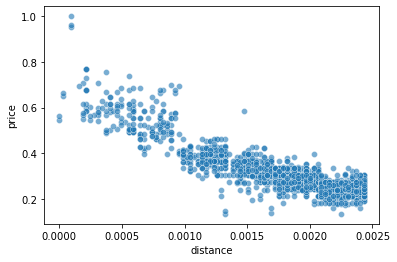

In [22]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=int)
translateTransform[:, 2] = np.array([-reducedData.min(), -reducedData.min(), 1], dtype=int)

scaleTransform = np.eye(homogenizedData.shape[1], dtype=int) * [1 / (reducedData.max() - reducedData.min()), 1 / (reducedData.max() - reducedData.min()), 1]

print("transformMatrix")
print(getShapeType(translateTransform @ scaleTransform))
print(translateTransform @ scaleTransform)

globalNormalizedData = (scaleTransform@translateTransform@homogenizedData.T).T
print("after global normalization, globalNormalizedData")
print(getSummaryStatistics(globalNormalizedData))
print(getShapeType(globalNormalizedData))
plot2d(globalNormalizedData)

I'm not sure global max-min normalization makes sense for data like this. Instead, let's try **max-min normalization per variable**.

transformMatrix
((3, 3), dtype('float64'))
[[ 3.55239787e-05  0.00000000e+00 -4.35000000e+03]
 [ 0.00000000e+00  1.26582278e-02 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
after per variable normalization, localNormalizedData
[[1. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
((1436, 3), dtype('float64'))


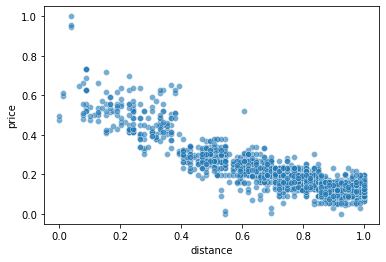

In [23]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=int)
translateTransform[:, 2] = np.array([-reducedData[:, 0].min(), -reducedData[:, 1].min(), 1], dtype=int)

scaleTransform = np.eye(scaleAgeData.shape[1]) * [1 / (reducedData[:, 0].max() - reducedData[:, 0].min()), 1 / (reducedData[:, 1].max() - reducedData[:, 1].min()), 1]

print("transformMatrix")
print(getShapeType(translateTransform @ scaleTransform))
print(translateTransform @ scaleTransform)

localNormalizedData = (scaleTransform@translateTransform@homogenizedData.T).T
print("after per variable normalization, localNormalizedData")
print(getSummaryStatistics(localNormalizedData))
print(getShapeType(localNormalizedData))
plot2d(localNormalizedData)

Max-min normalization will move everything to the unit square, but that may not help me see things more clearly. What if I try **z-scoring**: normalizing each feature by its mean and standard deviation instead?

In [ ]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=int)
translateTransform[:, 2] = np.array([-reducedData[:, 0].mean(), -reducedData[:, 1].mean(), 1], dtype=int)
print(getSummaryStatistics(homogenizedData))
print(translateTransform)

scaleTransform = np.eye(scaleAgeData.shape[1]) * [1 / reducedData[:, 0].std(), 1 / reducedData[:, 1].std(), 1]

print("transformMatrix")
print(getShapeType(translateTransform @ scaleTransform))
print(translateTransform @ scaleTransform)

localNormalizedData = (scaleTransform@translateTransform@homogenizedData.T).T
print("after per variable normalization, localNormalizedData")
print(getSummaryStatistics(localNormalizedData))
print(getShapeType(localNormalizedData))
plot2d(localNormalizedData)

Let's **rotate** the data by 270 degrees, because I like things to go up to the right

In [ ]:
rotateTransform = np.array([np.cos(np.radians(270)), -np.sin(np.radians(270)), 0, np.sin(np.radians(270)), np.cos(np.radians(270)), 0, 0, 0, 1]).reshape(3, 3)
print("transformMatrix")
print(getShapeType(rotateTransform))
print(rotateTransform)

rotatedData = (rotateTransform@homogenizedData.T).T
print("after rotating, rotatedData")
print(getSummaryStatistics(rotatedData))
print(getShapeType(rotatedData))
sns.scatterplot(x="km", y="price", palette="colorblind", sizes=(40, 200) , alpha=.6, data=pd.DataFrame(rotatedData, columns=["price", "km", ""]))

What if I wanted to rotate it *and translate it to be centered on zero*?

I would 

In [ ]:
transformMatrix = (rotateTransform@scaleTransform@translateTransform)
rotatedNormalizedData = (transformMatrix@homogenizedData.T).T

print("after per variable normalization, rotatedNormalizedData")
print(getSummaryStatistics(rotatedNormalizedData))
print(getShapeType(rotatedNormalizedData))
plot2d(rotatedNormalizedData)

What about 3D translation, scaling, and rotations?

3D translations are easy: 4x4 identity matrix (incl homogenous coordinate), with translations assigned to last column; last column's ith value operates on ith column of input.

3D scaling is also easy: 4x4 matrix (incl homogenous coordinate), with scaling for ith dimension assigned to the (i,i)th value; (i, i)th value operates on ith column of input.

3D rotations are harder. See below!


In [38]:
# yaw
def rotateTransformX(x):
    return np.array([1, 0, 0, 0, np.cos(np.radians(x)), -np.sin(np.radians(x)), 0, np.sin(np.radians(x)), np.cos(np.radians(x))]).reshape(3, 3)
rotateTransformX(90)

# pitch
def rotateTransformY(y):
    return np.array([np.cos(np.radians(y)), 0, np.sin(np.radians(y)), 0, 1, 0, -np.sin(np.radians(y)), 0, np.cos(np.radians(y))]).reshape(3, 3)

rotateTransformY(90)

# roll
def rotateTransformZ(z):
    return np.array([np.cos(np.radians(z)), -np.sin(np.radians(y)), 0, np.sin(np.radians(z)), np.cos(np.radians(y)), 0, 0, 0, 1]).reshape(3, 3)

rotateTransformY(90)


array([[ 6.123234e-17,  0.000000e+00,  1.000000e+00],
       [ 0.000000e+00,  1.000000e+00,  0.000000e+00],
       [-1.000000e+00,  0.000000e+00,  6.123234e-17]])

Some resources:
* https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20162017/LectureNotes/MATH/homogenous.html
* https://primer-computational-mathematics.github.io/book/d_geosciences/remote_sensing/Image_Transformations_and_Orthorectification.html
* https://www.informit.com/articles/article.aspx?p=2854376&seqNum=8
* https://towardsdatascience.com/normalization-techniques-in-python-using-numpy-b998aa81d754
* https://www.machinecurve.com/index.php/2020/11/19/how-to-normalize-or-standardize-a-dataset-in-python/

3D rotations:
* https://mathworld.wolfram.com/RotationMatrix.html
* https://jbush001.github.io/2017/01/19/visualizing-3d-matrix-rotations.html (I found this most useful!)